In [ ]:
import numpy as np
import sunode
import sunode.wrappers.as_theano
import pymc3 as pm
import arviz as az
from scipy.integrate import odeint
import matplotlib.pyplot as plt
#import theano-pymc as aesara

### SunODE solver - simple reaction network

In [ ]:
def reaction(y, t,  p):
    v = 0.0001
    OF = y[0]
    H_out = y[1]
    OFHb = y[2]
    k_on = p[0]
    k_off = p[1]
    dOF_dt = v*((OFHb*k_off) - (OF*H_out*k_on))
    dH_out_dt = v*((OFHb*k_off) - (OF*H_out*k_on))
    dOFHb_dt = v*((OF*H_out*k_on) - (OFHb*k_off)) 
    return [dOF_dt,dH_out_dt,dOFHb_dt ]


def reaction_sunode(t, y, p):
    """Right hand side of Lotka-Volterra equation.

    All inputs are dataclasses of sympy variables, or in the case
    of non-scalar variables numpy arrays of sympy variables.
    """
    v=0.0001
    return {
        'OF': v*((y.OFHb*(10**p.log_k_off)) - (y.OF*y.H_out*(10**p.log_k_on))),
        'H_out': v*((y.OFHb*(10**p.log_k_off)) - (y.OF*y.H_out*(10**p.log_k_on))),
        'OFHb': v*((y.OFHb*(10**p.log_k_off)) - (y.OF*y.H_out*(10**p.log_k_on))),
    }

np.random.seed(1234)
t = np.linspace(0, 1, 100)
k = np.array([1e6, 1e2])
y0 = [1,1,0]
y_out = odeint(reaction, y0, t, args=(k,))
y_obs = np.random.normal(y_out.T[0], 0.0025, np.size(y_out.T[0]))
plt.plot(t,y_out.T[0])
plt.plot(t,y_obs, 'o')

with pm.Model() as model:
    
    # Compute the parameters of the ode based on our prior parameters
    s=1 
    p_log_k_on = pm.Uniform('log_k_on', 5-s,7-s)
    p_log_k_off = pm.Uniform('log_k_off', 1-s,3-s)
    
    y_hat, _, problem, solver, _, _ = sunode.wrappers.as_theano.solve_ivp(
        y0={
	    # The initial conditions of the ode. Each variable
	    # needs to specify a theano or numpy variable and a shape.
	    # This dict can be nested.
            'OF': (np.array(1.0), ()),
            'H_out': (np.array(1.0), ()),
            'OFHb': (np.array(0.0), ()),
        },
        params={
	    # Each parameter of the ode. sunode will only compute derivatives
	    # with respect to theano variables. The shape needs to be specified
	    # as well. It it infered automatically for numpy variables.
	    # This dict can be nested.
            'log_k_on': (p_log_k_on, ()),
            'log_k_off': (p_log_k_off, ()),
            'extra': np.zeros(1),
        },
	    # A functions that computes the right-hand-side of the ode using
	    # sympy variables.
        rhs=reaction_sunode,
	    # The time points where we want to access the solution
        tvals=t,
        t0=t[0],
    )
    

    y_pred = y_hat['OF']
    print(y_pred)
    sd = pm.Uniform('sd', 0.001, 0.005)
    Y = pm.Normal('y_obs', mu=y_pred, sd=sd, observed=y_obs)
    trace = pm.sample(tune=1000, draws=1000, chains=2, cores=1)
    data = az.from_pymc3(trace=trace)

# plot results
az.plot_trace(data)
az.plot_posterior(data)


### single cycle transporter model


In [1]:
import numpy as np
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import theano 
import arviz as az
import sunode
import sunode.wrappers.as_theano
import sympy

# import multiprocessing as mp
# mp.set_start_method('fork')


def transporter_1c(y, t, theta, b):
    """ Single cycle model for a 1:1 secondary-active membrane transporter. 
    Assumes a fixed external concentration of the ion and substrate (e.g. experimental buffer solution)
    see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html 

    Args:
        y (numpy array): model state concentrations
        t (float): time point for integration
        theta (numpy array): model reaction rate constants
        b (numpy array): concentrations for the fixed external buffer solution (ion_out, substrate_out)

    Returns:
        (numpy array): integrated state concetrations at time point t (same order as y)
    """

    ### compartment size (in L)
    vol = 1
    v=1

    ### model parameters - reaction rate constants (in 1/s and 1/(Ms))
    rxn1_k1 = 0
    rxn1_k2 = 0
    rxn2_k1 = 10**theta[0]  # H on rate
    rxn2_k2 = 10**theta[1]  # H off rate
    rxn3_k1 = 10**theta[2]  # S off rate
    rxn3_k2 = 10**theta[3]  # S on rate
    rxn4_k1 = 10**theta[4]  # conf rate
    rxn4_k2 = 10**theta[5]  # conf rate
    rxn5_k1 = 0
    rxn5_k2 = 0
    rxn6_k1 = 10**theta[6]  # conf rate
    rxn6_k2 = 10**theta[7]  # conf rate
    rxn7_k1 = 0
    rxn7_k2 = 0
    rxn8_k1 = 0
    rxn8_k2 = 0
    rxn9_k1 = 0
    rxn9_k2 = 0
    rxn10_k1 = 0
    rxn10_k2 = 0
    rxn11_k1 = 10**theta[8]  # S on rate
    rxn11_k2 = 10**theta[9]  # S off rate
    rxn12_k1 = 10**theta[10]  # H off rate
    rxn12_k2 = (rxn2_k1*rxn3_k1*rxn4_k1*rxn6_k1*rxn11_k1*rxn12_k1)/(rxn2_k2*rxn3_k2*rxn4_k2*rxn6_k2*rxn11_k2)  # H on rate (cycle constraint)
  
    ### model state concentrations (in M)
    H_out = b[0]  # constant external ion concentration (e.g. buffer solution) 
    S_out = b[1]  # constant external substrate concentration (e.g. buffer solution) 
    
    H_in = y[0]  # internal ion concentration
    S_in = y[1]  # internal substrate concentation
    OF = y[2]  # fully unbound outward-facing transporter 
    IF = y[3]  # fully unbound inward-facing transporter
    OF_Hb = y[4]  # ion-bound only outward-facing transporter
    IF_Hb = y[5]  # ion-bound only inward-facing transporter
    OF_Sb = y[6]  # substrate-bound only outward-facing transporter
    IF_Sb = y[7]  # substrate-bound only inward-facing transporter
    OF_Hb_Sb = y[8]  # ion and substrate bound outward-facing transporter
    IF_Hb_Sb = y[9]  # ion and substrate bound inward-facing transporter

           
    ### reaction equations (from Tellurium)       
    vrxn1 = vol*(rxn1_k1*IF-rxn1_k2*OF)
    vrxn2 = vol*(rxn2_k1*OF*H_out-rxn2_k2*OF_Hb)
    vrxn3 = vol*(rxn3_k1*OF_Sb-rxn3_k2*OF*S_out)
    vrxn4 = vol*(rxn4_k1*OF_Hb-rxn4_k2*IF_Hb)
    vrxn5 = vol*(rxn5_k1*OF_Hb_Sb-rxn5_k2*OF_Hb*S_out)
    vrxn6 = vol*(rxn6_k1*IF_Sb-rxn6_k2*OF_Sb)
    vrxn7 = vol*(rxn7_k1*OF_Sb*H_out-rxn7_k2*OF_Hb_Sb)
    vrxn8 = vol*(rxn8_k1*OF_Hb_Sb-rxn8_k2*IF_Hb_Sb)
    vrxn9 = vol*(rxn9_k1*IF_Hb-rxn9_k2*IF*H_in)
    vrxn10 = vol*(rxn10_k1*IF*S_in-rxn10_k2*IF_Sb)
    vrxn11 = vol*(rxn11_k1*IF_Hb*S_in-rxn11_k2*IF_Hb_Sb)
    vrxn12 = vol*(rxn12_k1*IF_Hb_Sb-rxn12_k2*IF_Sb*H_in)

    ### ODE equations (from Tellurium)
    dOF_dt = v*(vrxn1 - vrxn2 + vrxn3)
    dOF_Hb_dt = v*(vrxn2 - vrxn4 + vrxn5)
    dIF_Hb_dt = v*(vrxn4 - vrxn9 - vrxn11)
    dS_in_dt = v*(-vrxn10 - vrxn11)
    dIF_Hb_Sb_dt = v*(vrxn8 + vrxn11 - vrxn12)
    dH_in_dt = v*(vrxn9 + vrxn12)
    dIF_Sb_dt = v*(-vrxn6 + vrxn10 + vrxn12)
    dOF_Sb_dt = v*(-vrxn3 + vrxn6 - vrxn7)
    dIF_dt = v*(-vrxn1 + vrxn9 - vrxn10)
    dOF_Hb_Sb_dt = v*(-vrxn5 + vrxn7 - vrxn8)
    ODE_list = [
        dH_in_dt,
        dS_in_dt,
        dOF_dt,
        dIF_dt,
        dOF_Hb_dt, 
        dIF_Hb_dt,
        dOF_Sb_dt,
        dIF_Sb_dt, 
        dOF_Hb_Sb_dt,
        dIF_Hb_Sb_dt,   
    ]
    return np.stack(ODE_list)


def transporter_s1(t, y, p):
    """ Single cycle model for a 1:1 secondary-active membrane transporter. 
    Assumes a fixed external concentration of the ion and substrate (e.g. experimental buffer solution)
    see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html 

    Args:
        y (numpy array): model state concentrations
        t (float): time point for integration
        theta (numpy array): model reaction rate constants
        b (numpy array): concentrations for the fixed external buffer solution (ion_out, substrate_out)

    Returns:
        (numpy array): integrated state concetrations at time point t (same order as y)
    """

    ### compartment size (in L)
    vol = 1
    v=1

    ### model parameters - reaction rate constants (in 1/s and 1/(Ms))
    rxn1_k1 = 0
    rxn1_k2 = 0
    rxn2_k1 = 10**p.log_rxn2_k1  # H on rate
    rxn2_k2 = 10**p.log_rxn2_k2  # H off rate
    rxn3_k1 = 10**p.log_rxn3_k1  # S off rate
    rxn3_k2 = 10**p.log_rxn3_k2   # S on rate
    rxn4_k1 = 10**p.log_rxn4_k1   # conf rate
    rxn4_k2 = 10**p.log_rxn4_k2   # conf rate
    rxn5_k1 = 0
    rxn5_k2 = 0
    rxn6_k1 = 10**p.log_rxn6_k1   # conf rate
    rxn6_k2 = 10**p.log_rxn6_k2   # conf rate
    rxn7_k1 = 0
    rxn7_k2 = 0
    rxn8_k1 = 0
    rxn8_k2 = 0
    rxn9_k1 = 0
    rxn9_k2 = 0
    rxn10_k1 = 0
    rxn10_k2 = 0
    rxn11_k1 = 10**p.log_rxn11_k1   # S on rate
    rxn11_k2 = 10**p.log_rxn11_k2   # S off rate
    rxn12_k1 = 10**p.log_rxn12_k1   # H off rate
    rxn12_k2 = (rxn2_k1*rxn3_k1*rxn4_k1*rxn6_k1*rxn11_k1*rxn12_k1)/(rxn2_k2*rxn3_k2*rxn4_k2*rxn6_k2*rxn11_k2)  # H on rate (cycle constraint)
  
    ### model state concentrations (in M)
    H_out = 1e-7  # constant external ion concentration (e.g. buffer solution) 
    S_out = 0.001  # constant external substrate concentration (e.g. buffer solution) 
    
    H_in = y.H_in  # internal ion concentration
    S_in = y.S_in  # internal substrate concentation
    OF = y.OF  # fully unbound outward-facing transporter 
    IF = y.IF  # fully unbound inward-facing transporter
    OF_Hb = y.OF_Hb  # ion-bound only outward-facing transporter
    IF_Hb = y.IF_Hb  # ion-bound only inward-facing transporter
    OF_Sb = y.OF_Sb  # substrate-bound only outward-facing transporter
    IF_Sb = y.IF_Sb  # substrate-bound only inward-facing transporter
    OF_Hb_Sb = y.OF_Hb_Sb  # ion and substrate bound outward-facing transporter
    IF_Hb_Sb = y.IF_Hb_Sb  # ion and substrate bound inward-facing transporter

           
    ### reaction equations (from Tellurium)       
    vrxn1 = vol*(rxn1_k1*IF-rxn1_k2*OF)
    vrxn2 = vol*(rxn2_k1*OF*H_out-rxn2_k2*OF_Hb)
    vrxn3 = vol*(rxn3_k1*OF_Sb-rxn3_k2*OF*S_out)
    vrxn4 = vol*(rxn4_k1*OF_Hb-rxn4_k2*IF_Hb)
    vrxn5 = vol*(rxn5_k1*OF_Hb_Sb-rxn5_k2*OF_Hb*S_out)
    vrxn6 = vol*(rxn6_k1*IF_Sb-rxn6_k2*OF_Sb)
    vrxn7 = vol*(rxn7_k1*OF_Sb*H_out-rxn7_k2*OF_Hb_Sb)
    vrxn8 = vol*(rxn8_k1*OF_Hb_Sb-rxn8_k2*IF_Hb_Sb)
    vrxn9 = vol*(rxn9_k1*IF_Hb-rxn9_k2*IF*H_in)
    vrxn10 = vol*(rxn10_k1*IF*S_in-rxn10_k2*IF_Sb)
    vrxn11 = vol*(rxn11_k1*IF_Hb*S_in-rxn11_k2*IF_Hb_Sb)
    vrxn12 = vol*(rxn12_k1*IF_Hb_Sb-rxn12_k2*IF_Sb*H_in)

    ### ODE equations (from Tellurium)
    dOF_dt = v*(vrxn1 - vrxn2 + vrxn3)
    dOF_Hb_dt = v*(vrxn2 - vrxn4 + vrxn5)
    dIF_Hb_dt = v*(vrxn4 - vrxn9 - vrxn11)
    dS_in_dt = v*(-vrxn10 - vrxn11)
    dIF_Hb_Sb_dt = v*(vrxn8 + vrxn11 - vrxn12)
    dH_in_dt = v*(vrxn9 + vrxn12)
    dIF_Sb_dt = v*(-vrxn6 + vrxn10 + vrxn12)
    dOF_Sb_dt = v*(-vrxn3 + vrxn6 - vrxn7)
    dIF_dt = v*(-vrxn1 + vrxn9 - vrxn10)
    dOF_Hb_Sb_dt = v*(-vrxn5 + vrxn7 - vrxn8)
    ODE_dict = {
        "H_in" : dH_in_dt,
        "S_in" : dS_in_dt,
        "OF": dOF_dt,
        "IF": dIF_dt,
        "OF_Hb": dOF_Hb_dt, 
        "IF_Hb": dIF_Hb_dt,
        "OF_Sb": dOF_Sb_dt,
        "IF_Sb": dIF_Sb_dt, 
        "OF_Hb_Sb": dOF_Hb_Sb_dt,
        "IF_Hb_Sb": dIF_Hb_Sb_dt,   
    }
    
    return ODE_dict

def transporter_s2(t, y, p):
    """ Single cycle model for a 1:1 secondary-active membrane transporter. 
    Assumes a fixed external concentration of the ion and substrate (e.g. experimental buffer solution)
    see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html 

    Args:
        y (numpy array): model state concentrations
        t (float): time point for integration
        theta (numpy array): model reaction rate constants
        b (numpy array): concentrations for the fixed external buffer solution (ion_out, substrate_out)

    Returns:
        (numpy array): integrated state concetrations at time point t (same order as y)
    """

    ### compartment size (in L)
    vol = 1
    v=1

    ### model parameters - reaction rate constants (in 1/s and 1/(Ms))
    rxn1_k1 = 0
    rxn1_k2 = 0
    rxn2_k1 = 10**p.log_rxn2_k1  # H on rate
    rxn2_k2 = 10**p.log_rxn2_k2  # H off rate
    rxn3_k1 = 10**p.log_rxn3_k1  # S off rate
    rxn3_k2 = 10**p.log_rxn3_k2   # S on rate
    rxn4_k1 = 10**p.log_rxn4_k1   # conf rate
    rxn4_k2 = 10**p.log_rxn4_k2   # conf rate
    rxn5_k1 = 0
    rxn5_k2 = 0
    rxn6_k1 = 10**p.log_rxn6_k1   # conf rate
    rxn6_k2 = 10**p.log_rxn6_k2   # conf rate
    rxn7_k1 = 0
    rxn7_k2 = 0
    rxn8_k1 = 0
    rxn8_k2 = 0
    rxn9_k1 = 0
    rxn9_k2 = 0
    rxn10_k1 = 0
    rxn10_k2 = 0
    rxn11_k1 = 10**p.log_rxn11_k1   # S on rate
    rxn11_k2 = 10**p.log_rxn11_k2   # S off rate
    rxn12_k1 = 10**p.log_rxn12_k1   # H off rate
    rxn12_k2 = (rxn2_k1*rxn3_k1*rxn4_k1*rxn6_k1*rxn11_k1*rxn12_k1)/(rxn2_k2*rxn3_k2*rxn4_k2*rxn6_k2*rxn11_k2)  # H on rate (cycle constraint)
  
    ### model state concentrations (in M)
    H_out = 5e-8  # constant external ion concentration (e.g. buffer solution) 
    S_out = 0.001  # constant external substrate concentration (e.g. buffer solution) 
    
    H_in = y.H_in  # internal ion concentration
    S_in = y.S_in  # internal substrate concentation
    OF = y.OF  # fully unbound outward-facing transporter 
    IF = y.IF  # fully unbound inward-facing transporter
    OF_Hb = y.OF_Hb  # ion-bound only outward-facing transporter
    IF_Hb = y.IF_Hb  # ion-bound only inward-facing transporter
    OF_Sb = y.OF_Sb  # substrate-bound only outward-facing transporter
    IF_Sb = y.IF_Sb  # substrate-bound only inward-facing transporter
    OF_Hb_Sb = y.OF_Hb_Sb  # ion and substrate bound outward-facing transporter
    IF_Hb_Sb = y.IF_Hb_Sb  # ion and substrate bound inward-facing transporter

           
    ### reaction equations (from Tellurium)       
    vrxn1 = vol*(rxn1_k1*IF-rxn1_k2*OF)
    vrxn2 = vol*(rxn2_k1*OF*H_out-rxn2_k2*OF_Hb)
    vrxn3 = vol*(rxn3_k1*OF_Sb-rxn3_k2*OF*S_out)
    vrxn4 = vol*(rxn4_k1*OF_Hb-rxn4_k2*IF_Hb)
    vrxn5 = vol*(rxn5_k1*OF_Hb_Sb-rxn5_k2*OF_Hb*S_out)
    vrxn6 = vol*(rxn6_k1*IF_Sb-rxn6_k2*OF_Sb)
    vrxn7 = vol*(rxn7_k1*OF_Sb*H_out-rxn7_k2*OF_Hb_Sb)
    vrxn8 = vol*(rxn8_k1*OF_Hb_Sb-rxn8_k2*IF_Hb_Sb)
    vrxn9 = vol*(rxn9_k1*IF_Hb-rxn9_k2*IF*H_in)
    vrxn10 = vol*(rxn10_k1*IF*S_in-rxn10_k2*IF_Sb)
    vrxn11 = vol*(rxn11_k1*IF_Hb*S_in-rxn11_k2*IF_Hb_Sb)
    vrxn12 = vol*(rxn12_k1*IF_Hb_Sb-rxn12_k2*IF_Sb*H_in)

    ### ODE equations (from Tellurium)
    dOF_dt = v*(vrxn1 - vrxn2 + vrxn3)
    dOF_Hb_dt = v*(vrxn2 - vrxn4 + vrxn5)
    dIF_Hb_dt = v*(vrxn4 - vrxn9 - vrxn11)
    dS_in_dt = v*(-vrxn10 - vrxn11)
    dIF_Hb_Sb_dt = v*(vrxn8 + vrxn11 - vrxn12)
    dH_in_dt = v*(vrxn9 + vrxn12)
    dIF_Sb_dt = v*(-vrxn6 + vrxn10 + vrxn12)
    dOF_Sb_dt = v*(-vrxn3 + vrxn6 - vrxn7)
    dIF_dt = v*(-vrxn1 + vrxn9 - vrxn10)
    dOF_Hb_Sb_dt = v*(-vrxn5 + vrxn7 - vrxn8)
    ODE_dict = {
        "H_in" : dH_in_dt,
        "S_in" : dS_in_dt,
        "OF": dOF_dt,
        "IF": dIF_dt,
        "OF_Hb": dOF_Hb_dt, 
        "IF_Hb": dIF_Hb_dt,
        "OF_Sb": dOF_Sb_dt,
        "IF_Sb": dIF_Sb_dt, 
        "OF_Hb_Sb": dOF_Hb_Sb_dt,
        "IF_Hb_Sb": dIF_Hb_Sb_dt,   
    }
    
    return ODE_dict

def transporter_st(t, y, p):
    """ Single cycle model for a 1:1 secondary-active membrane transporter. 
    Assumes a fixed external concentration of the ion and substrate (e.g. experimental buffer solution)
    see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html 

    Args:
        y (numpy array): model state concentrations
        t (float): time point for integration
        theta (numpy array): model reaction rate constants
        b (numpy array): concentrations for the fixed external buffer solution (ion_out, substrate_out)

    Returns:
        (numpy array): integrated state concetrations at time point t (same order as y)
    """

    ### compartment size (in L)
    vol = 1
    v=1

    ### model parameters - reaction rate constants (in 1/s and 1/(Ms))
    rxn1_k1 = 0
    rxn1_k2 = 0
    rxn2_k1 = 10**p.log_rxn2_k1  # H on rate
    rxn2_k2 = 10**p.log_rxn2_k2  # H off rate
    rxn3_k1 = 10**p.log_rxn3_k1  # S off rate
    rxn3_k2 = 10**p.log_rxn3_k2   # S on rate
    rxn4_k1 = 10**p.log_rxn4_k1   # conf rate
    rxn4_k2 = 10**p.log_rxn4_k2   # conf rate
    rxn5_k1 = 0
    rxn5_k2 = 0
    rxn6_k1 = 10**p.log_rxn6_k1   # conf rate
    rxn6_k2 = 10**p.log_rxn6_k2   # conf rate
    rxn7_k1 = 0
    rxn7_k2 = 0
    rxn8_k1 = 0
    rxn8_k2 = 0
    rxn9_k1 = 0
    rxn9_k2 = 0
    rxn10_k1 = 0
    rxn10_k2 = 0
    rxn11_k1 = 10**p.log_rxn11_k1   # S on rate
    rxn11_k2 = 10**p.log_rxn11_k2   # S off rate
    rxn12_k1 = 10**p.log_rxn12_k1   # H off rate
    rxn12_k2 = (rxn2_k1*rxn3_k1*rxn4_k1*rxn6_k1*rxn11_k1*rxn12_k1)/(rxn2_k2*rxn3_k2*rxn4_k2*rxn6_k2*rxn11_k2)  # H on rate (cycle constraint)
  
    ### model state concentrations (in M)
    
    expr = t-5
    if (expr).is_positive:
        H_out = 1e-7
        print(expr) 
        print('using 1e-7')
    else:
        H_out = 5e-8  # constant external ion concentration (e.g. buffer solution)
        print(expr) 
        print('using 5e-8')
       
    S_out = 0.001  # constant external substrate concentration (e.g. buffer solution) 
    
    H_in = y.H_in  # internal ion concentration
    S_in = y.S_in  # internal substrate concentation
    OF = y.OF  # fully unbound outward-facing transporter 
    IF = y.IF  # fully unbound inward-facing transporter
    OF_Hb = y.OF_Hb  # ion-bound only outward-facing transporter
    IF_Hb = y.IF_Hb  # ion-bound only inward-facing transporter
    OF_Sb = y.OF_Sb  # substrate-bound only outward-facing transporter
    IF_Sb = y.IF_Sb  # substrate-bound only inward-facing transporter
    OF_Hb_Sb = y.OF_Hb_Sb  # ion and substrate bound outward-facing transporter
    IF_Hb_Sb = y.IF_Hb_Sb  # ion and substrate bound inward-facing transporter

           
    ### reaction equations (from Tellurium)       
    vrxn1 = vol*(rxn1_k1*IF-rxn1_k2*OF)
    vrxn2 = vol*(rxn2_k1*OF*H_out-rxn2_k2*OF_Hb)
    vrxn3 = vol*(rxn3_k1*OF_Sb-rxn3_k2*OF*S_out)
    vrxn4 = vol*(rxn4_k1*OF_Hb-rxn4_k2*IF_Hb)
    vrxn5 = vol*(rxn5_k1*OF_Hb_Sb-rxn5_k2*OF_Hb*S_out)
    vrxn6 = vol*(rxn6_k1*IF_Sb-rxn6_k2*OF_Sb)
    vrxn7 = vol*(rxn7_k1*OF_Sb*H_out-rxn7_k2*OF_Hb_Sb)
    vrxn8 = vol*(rxn8_k1*OF_Hb_Sb-rxn8_k2*IF_Hb_Sb)
    vrxn9 = vol*(rxn9_k1*IF_Hb-rxn9_k2*IF*H_in)
    vrxn10 = vol*(rxn10_k1*IF*S_in-rxn10_k2*IF_Sb)
    vrxn11 = vol*(rxn11_k1*IF_Hb*S_in-rxn11_k2*IF_Hb_Sb)
    vrxn12 = vol*(rxn12_k1*IF_Hb_Sb-rxn12_k2*IF_Sb*H_in)

    ### ODE equations (from Tellurium)
    dOF_dt = v*(vrxn1 - vrxn2 + vrxn3)
    dOF_Hb_dt = v*(vrxn2 - vrxn4 + vrxn5)
    dIF_Hb_dt = v*(vrxn4 - vrxn9 - vrxn11)
    dS_in_dt = v*(-vrxn10 - vrxn11)
    dIF_Hb_Sb_dt = v*(vrxn8 + vrxn11 - vrxn12)
    dH_in_dt = v*(vrxn9 + vrxn12)
    dIF_Sb_dt = v*(-vrxn6 + vrxn10 + vrxn12)
    dOF_Sb_dt = v*(-vrxn3 + vrxn6 - vrxn7)
    dIF_dt = v*(-vrxn1 + vrxn9 - vrxn10)
    dOF_Hb_Sb_dt = v*(-vrxn5 + vrxn7 - vrxn8)
    ODE_dict = {
        "H_in" : dH_in_dt,
        "S_in" : dS_in_dt,
        "OF": dOF_dt,
        "IF": dIF_dt,
        "OF_Hb": dOF_Hb_dt, 
        "IF_Hb": dIF_Hb_dt,
        "OF_Sb": dOF_Sb_dt,
        "IF_Sb": dIF_Sb_dt, 
        "OF_Hb_Sb": dOF_Hb_Sb_dt,
        "IF_Hb_Sb": dIF_Hb_Sb_dt,   
    }
    
    return ODE_dict

### generate synthetic data

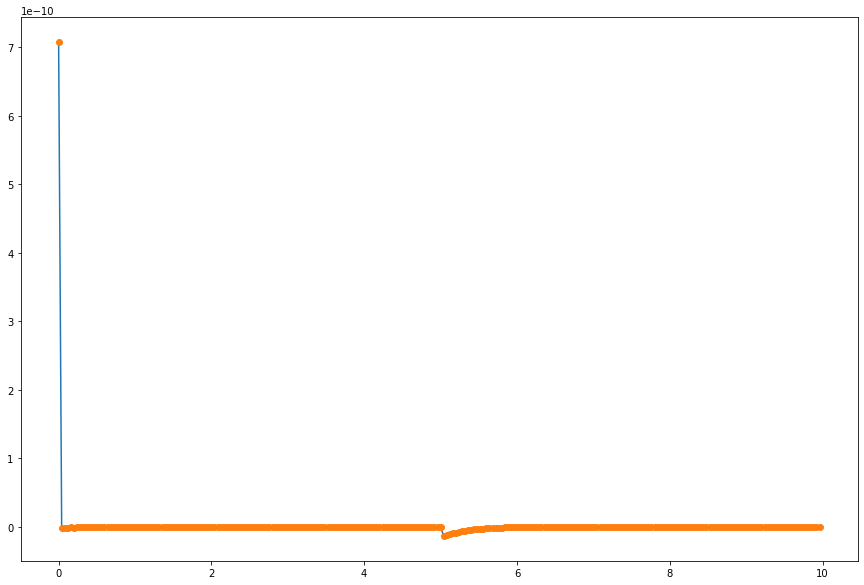

In [2]:
np.random.seed(1)

### time steps
sample_rate = 25  # sample rate (x samples/sec)
stage_time = 5 # how long each experiment stage is (in sec)

t1_test = np.linspace(0,stage_time,int(sample_rate*stage_time), endpoint=False)
t2_test = np.linspace(stage_time,2*stage_time,int(sample_rate*stage_time), endpoint=False)

t1 = np.linspace(0,stage_time,int(sample_rate*stage_time), endpoint=False)
t2 = np.linspace(stage_time,2*stage_time,int(sample_rate*stage_time), endpoint=False)
t3 = np.linspace(2*stage_time,3*stage_time,int(sample_rate*stage_time),endpoint=False)

t_tot = np.hstack([t1,t2,t3])
t_23 = np.hstack([t2,t3])
t_s1_and_s2 = np.hstack([t1,t2])
t_s1_and_s2_test = np.hstack([t1_test,t2_test])

### initial concentrations
y0 = np.array([
    1e-7,
    1e-3,
    2.833e-08,
    2.125e-08,
    2.833e-08,
    2.833e-08,
    2.125e-08,
    2.125e-08,
    2.125e-08,
    2.833e-08,
])

### experimental buffer concentrations
b1 = np.array([1e-07, 0.001])
b2 = np.array([5e-08, 0.001])
b3 = np.array([1e-07, 0.001])

### rate constants
k_H_on = 1e10
k_H_off = 1e3
k_S_on = 1e7
k_S_off = 1e3
k_conf = 1e2
theta = np.array([
    np.log10(k_H_on),
    np.log10(k_H_off),
    np.log10(k_S_off),
    np.log10(k_S_on),
    np.log10(k_conf),
    np.log10(k_conf),
    np.log10(k_conf),
    np.log10(k_conf),
    np.log10(k_S_on),  
    np.log10(k_S_off),  
    np.log10(k_H_off),  
])
std_true = 1e-13

### integrate multiple experiments
s1 = odeint(transporter_1c, y0=y0, t=t1, args=(theta,b1), atol=1e-16, rtol=1e-14)
s2 = odeint(transporter_1c, y0=s1[-1],t=t2, args=(theta,b2), atol=1e-16, rtol=1e-14)
s3 = odeint(transporter_1c, y0=s2[-1],t=t3, args=(theta,b3), atol=1e-16, rtol=1e-14)
# #D = np.transpose(np.vstack([s2,s3]))


D = np.transpose(np.vstack([s1,s2]))

# vol*(rxn12_k1*IF_Hb_Sb-rxn12_k2*IF_Sb*H_in)
y_true = np.array((0.0001*((1e3*D[9])-(1e10*D[7]*D[0]))))

# print(D[9][0])
# print(D[7][0])
# print(D[0][0])
# print(y_true[0])
# print(y_true[1])
# print(y_true[2])
# print(0.0001*((1e3*D[9][0])-(1e10*D[7][0]*D[0][0])))
# print(0.0001*((1e3*D[9][1])-(1e10*D[7][1]*D[0][1])))

# print(D[9][1])
# print(D[7][1])
# print(D[0][1])


#y_true2 = np.array((0.0001*(1e3*D_s1[9]-1e10*D_s1[7]*D_s1[0])))

noise = np.random.normal(0,std_true, np.size(y_true))
y_obs = y_true + noise 
plt.figure(figsize=(15,10))
# plt.plot(t_23, y_true)
# plt.plot(t_23, y_true2, '--')
# plt.plot(t_23, y_obs, 'o')
plt.plot(t_s1_and_s2, y_true)
plt.plot(t_s1_and_s2, y_obs, 'o')
#plt.plot(t1, y_true2)



#### testing ODE integration using random parameter sets - SciPy ODE integrator


[10.  3.  3.  7.  2.  2.  2.  2.  7.  3.  3.]
[ 8.40199684  0.61180356  3.0951421   6.86284592 -0.08397014  2.73083739
  2.26406071  2.92482408  4.86727324  4.5091669   1.33229484]
2.2373197403048835
 lsoda--  at start of problem, too much accuracy     
       requested for precision of machine..  see tolsf (=r1) 
      in above message,  r1 =  0.4037174635001D+03
 lsoda--  at start of problem, too much accuracy     
       requested for precision of machine..  see tolsf (=r1) 
      in above message,  r1 =  0.4440892098501D+04
[10.  3.  3.  7.  2.  2.  2.  2.  7.  3.  3.]
[10.11611095  4.71177617  0.13398257  5.94617476  4.23753426  4.06825765
  2.23064356  4.19964964  9.69883595  4.95844199  5.12469266]
7.6574997351815846
 lsoda--  at start of problem, too much accuracy     
       requested for precision of machine..  see tolsf (=r1) 
      in above message,  r1 =  0.4037174635001D+03
 lsoda--  at t (=r1), too much accuracy requested    
[10.  3.  3.  7.  2.  2.  2.  2.  7.  3.  3.]

/opt/miniconda3/envs/pymc3_sunode_env/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_57971/1459013958.py:25: RuntimeWarning: overflow encountered in multiply
  y_test = np.array((0.0001*((theta_test[-1]*D_test[9])-((10**log_rxn12_k2_test)*D_test[7]*D_test[0]))))
/opt/miniconda3/envs/pymc3_sunode_env/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/miniconda3/envs/pymc3_sunode_env/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, O

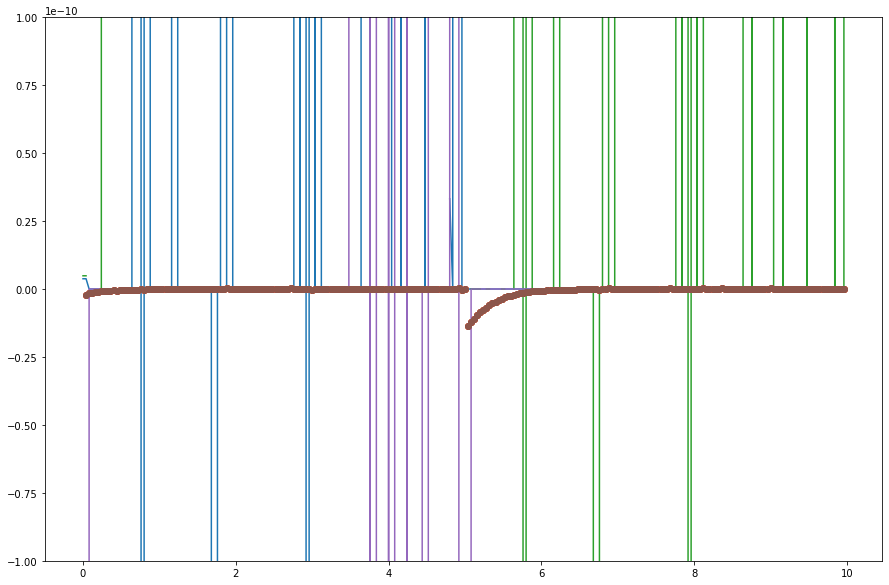

In [3]:
plt.figure(figsize=(15,10))
y_tmp = []
for i in range(3):
    theta_test = np.array([
        np.random.uniform(7,13),
        np.random.uniform(0,6),
        np.random.uniform(0,6),
        np.random.uniform(4,10),
        np.random.uniform(-1,5),
        np.random.uniform(-1,5),
        np.random.uniform(-1,5),
        np.random.uniform(-1,5),
        np.random.uniform(4,10),  
        np.random.uniform(0,6),  
        np.random.uniform(0,6),  
    ])
    print(theta)
    print(theta_test)
    log_rxn12_k2_test = ((theta_test[0]+theta_test[2]+theta_test[4]+theta_test[6]+theta_test[8]+theta_test[10])-(theta_test[1]+theta_test[3]+theta_test[5]+theta_test[7]+theta_test[9]))
    print(log_rxn12_k2_test)
    s1_test = odeint(transporter_1c, y0=y0, t=t1_test, args=(theta_test,b1), atol=1e-19, rtol=1e-17)
    s2_test = odeint(transporter_1c, y0=s1_test[-1], t=t1_test, args=(theta_test,b2), atol=1e-19, rtol=1e-17)

    D_test = np.transpose(np.vstack([s1_test,s2_test]))
    y_test = np.array((0.0001*((theta_test[-1]*D_test[9])-((10**log_rxn12_k2_test)*D_test[7]*D_test[0]))))
    y_tmp.append(y_test)
    plt.plot(t_s1_and_s2_test,y_test)
    plt.ylim(-1e-10,1e-10)
    plt.plot(t_s1_and_s2, y_obs, 'o')


#### testing ODE integration using random parameter sets - SunODE ODE integrator

In [ ]:
problem = sunode.symode.SympyProblem(
    params={
        # We need to specify the shape of each parameter.
        # Any empty tuple corresponds to a scalar value.
        'alpha': (),
        'beta': (),
        'gamma': (),
        'delta': (),
    },
    states={
        # The same for all state variables
        'hares': (),
        'lynx': (),
    },
    rhs_sympy=transporter_s1,
    derivative_params=[
        # We need to specify with respect to which variables
        # gradients should be computed.
        ('alpha',),
        ('beta',),
    ],
)

# The solver generates uses numba and sympy to generate optimized C functions
# for the right-hand-side and if necessary for the jacobian, adoint and
# quadrature functions for gradients.
#solver = sunode.solver.Solver(problem, compute_sens=False, solver='BDF')
solver = sunode.solver.Solver(problem, solver='BDF')


tvals = np.linspace(0, 10)
# We can use numpy structured arrays as input, so that we don't need
# to think about how the different variables are stored in the array.
# This does not introduce any runtime overhead during solving.
y0 = np.zeros((), dtype=problem.state_dtype)
y0['hares'] = 1
y0['lynx'] = 0.1

# We can also specify the parameters by name:
solver.set_params_dict({
    'alpha': 0.1,
    'beta': 0.2,
    'gamma': 0.3,
    'delta': 0.4,
})

output = solver.make_output_buffers(tvals)
solver.solve(t0=0, tvals=tvals, y0=y0, y_out=output)

# We can convert the solution to an xarray Dataset
solver.as_xarray(tvals, output).solution_hares.plot()

# Or we can convert it to a numpy record array
plt.plot(output.view(problem.state_dtype)['hares']

### Run Bayesian inference

In [ ]:

seed = 1

with pm.Model() as model:
    np.random.seed(seed)
    stdev = pm.Uniform("noise_stdev", std_true*0.25, std_true*1.50)
    s=1  # shift priors so the true value isn't centered
    log_rxn2_k1 = pm.Uniform("log_rxn2_k1", 7-s, 13-s, testval=np.random.uniform(7-s, 13-s))
    log_rxn2_k2 = pm.Uniform("log_rxn2_k2", 0-s, 6-s, testval=np.random.uniform(0-s, 6-s))
    log_rxn3_k1 = pm.Uniform("log_rxn3_k1", 0-s, 6-s, testval=np.random.uniform(0-s, 6-s))
    log_rxn3_k2 = pm.Uniform("log_rxn3_k2", 4-s, 10-s, testval=np.random.uniform(4-s, 10-s))
    log_rxn4_k1 = pm.Uniform("log_rxn4_k1", -1-s, 5-s, testval=np.random.uniform(-1-s, 5-s))
    log_rxn4_k2 = pm.Uniform("log_rxn4_k2", -1-s, 5-s, testval=np.random.uniform(-1-s, 5-s))
    log_rxn6_k1 = pm.Uniform("log_rxn6_k1", -1-s, 5-s, testval=np.random.uniform(-1-s, 5-s))
    log_rxn6_k2 = pm.Uniform("log_rxn6_k2", -1-s, 5-s, testval=np.random.uniform(-1-s, 5-s))
    log_rxn11_k1 = pm.Uniform("log_rxn11_k1", 4-s, 10-s, testval=np.random.uniform(4-s, 10-s))
    log_rxn11_k2 = pm.Uniform("log_rxn11_k2", 0-s, 6-s, testval=np.random.uniform(0-s, 6-s))
    log_rxn12_k1 = pm.Uniform("log_rxn12_k1", 0-s, 6-s, testval=np.random.uniform(0-s, 6-s))
    # log_rxn12_k2 = pm.Deterministic('log_rxn12_k2', ((log_rxn2_k1+log_rxn3_k1+log_rxn4_k1+log_rxn6_k1+log_rxn11_k1+log_rxn12_k1)-(log_rxn2_k2+log_rxn3_k2+log_rxn4_k2+log_rxn6_k2+log_rxn11_k2)))
    log_rxn12_k2 = ((log_rxn2_k1+log_rxn3_k1+log_rxn4_k1+log_rxn6_k1+log_rxn11_k1+log_rxn12_k1)-(log_rxn2_k2+log_rxn3_k2+log_rxn4_k2+log_rxn6_k2+log_rxn11_k2))
    theta_sample = [
        log_rxn2_k1, 
        log_rxn2_k2,
        log_rxn3_k1, 
        log_rxn3_k2,
        log_rxn4_k1, 
        log_rxn4_k2,
        log_rxn6_k1, 
        log_rxn6_k2,
        log_rxn11_k1, 
        log_rxn11_k2,
        log_rxn12_k1, 
    ]
    y_hat, _, problem, solver, _, _ = sunode.wrappers.as_theano.solve_ivp(
        y0={
        # The initial conditions of the ode. Each variable
        # needs to specify a theano or numpy variable and a shape.
        # This dict can be nested.
            "H_in" : (np.array(y0[0]), ()),
            "S_in" : (np.array(y0[1]), ()),
            "OF": (np.array(y0[2]), ()),
            "IF": (np.array(y0[3]), ()),
            "OF_Hb": (np.array(y0[4]), ()), 
            "IF_Hb": (np.array(y0[5]), ()),
            "OF_Sb": (np.array(y0[6]), ()),
            "IF_Sb": (np.array(y0[7]), ()), 
            "OF_Hb_Sb": (np.array(y0[8]), ()),
            "IF_Hb_Sb": (np.array(y0[9]), ()),   
        },
        params={
        # Each parameter of the ode. sunode will only compute derivatives
        # with respect to theano variables. The shape needs to be specified
        # as well. It it infered automatically for numpy variables.
        # This dict can be nested.
            'log_rxn2_k1': (log_rxn2_k1, ()),
            'log_rxn2_k2': (log_rxn2_k2, ()),
            'log_rxn3_k1': (log_rxn3_k1, ()),
            'log_rxn3_k2': (log_rxn3_k2, ()),
            'log_rxn4_k1': (log_rxn4_k1, ()),
            'log_rxn4_k2': (log_rxn4_k2, ()),
            'log_rxn6_k1': (log_rxn6_k1, ()),
            'log_rxn6_k2': (log_rxn6_k2, ()),
            'log_rxn11_k1': (log_rxn11_k1, ()),
            'log_rxn11_k2': (log_rxn11_k2, ()),
            'log_rxn12_k1': (log_rxn12_k1, ()),
            'extra': np.zeros(1),
        },
        # A functions that computes the right-hand-side of the ode using
        # sympy variables.
        rhs=transporter_s1,
        # The time points where we want to access the solution
        tvals=t1,
        t0=t1[0],
    )
    
    y_hat2, _, problem2, solver2, _, _ = sunode.wrappers.as_theano.solve_ivp(
        y0={
        # The initial conditions of the ode. Each variable
        # needs to specify a theano or numpy variable and a shape.
        # This dict can be nested.
            "H_in" : (y_hat['H_in'][-1], ()),
            "S_in" : (y_hat['S_in'][-1], ()),
            "OF": (y_hat['OF'][-1], ()),
            "IF": (y_hat['IF'][-1], ()),
            "OF_Hb": (y_hat['OF_Hb'][-1], ()), 
            "IF_Hb": (y_hat['IF_Hb'][-1], ()),
            "OF_Sb": (y_hat['OF_Sb'][-1], ()),
            "IF_Sb": (y_hat['IF_Sb'][-1], ()), 
            "OF_Hb_Sb": (y_hat['OF_Hb_Sb'][-1], ()),
            "IF_Hb_Sb": (y_hat['IF_Hb_Sb'][-1], ()),   
        },
        params={
        # Each parameter of the ode. sunode will only compute derivatives
        # with respect to theano variables. The shape needs to be specified
        # as well. It it infered automatically for numpy variables.
        # This dict can be nested.
            'log_rxn2_k1': (log_rxn2_k1, ()),
            'log_rxn2_k2': (log_rxn2_k2, ()),
            'log_rxn3_k1': (log_rxn3_k1, ()),
            'log_rxn3_k2': (log_rxn3_k2, ()),
            'log_rxn4_k1': (log_rxn4_k1, ()),
            'log_rxn4_k2': (log_rxn4_k2, ()),
            'log_rxn6_k1': (log_rxn6_k1, ()),
            'log_rxn6_k2': (log_rxn6_k2, ()),
            'log_rxn11_k1': (log_rxn11_k1, ()),
            'log_rxn11_k2': (log_rxn11_k2, ()),
            'log_rxn12_k1': (log_rxn12_k1, ()),
            'extra': np.zeros(1),
        },
        # A functions that computes the right-hand-side of the ode using
        # sympy variables.
        rhs=transporter_s2,
        # The time points where we want to access the solution
        tvals=t2,
        t0=t2[0],
    )

    lib = sunode._cvodes.lib
    lib.CVodeSStolerances(solver._ode, 1e-17, 1e-19)  # rel tol, abs tol (17,19)
    lib.CVodeSStolerances(solver2._ode, 1e-17, 1e-19)  # rel tol, abs tol
    lib.CVodeSetMaxNumSteps(solver._ode, 1000)
    lib.CVodeSetMaxNumStepsB(solver._ode, solver._odeB, 1000)
    lib.CVodeSetMaxNumSteps(solver2._ode, 1000)
    lib.CVodeSetMaxNumStepsB(solver2._ode, solver._odeB, 1000)

    lib.CVodeSensToggleOff(solver._ode)
    lib.CVodeSensToggleOff(solver2._ode)
    
    
    IF_Hb_Sb_sample = pm.math.concatenate([y_hat['IF_Hb_Sb'],y_hat2['IF_Hb_Sb']])
    IF_Sb_sample = pm.math.concatenate([y_hat['IF_Sb'],y_hat2['IF_Sb']])
    H_in_sample = pm.math.concatenate([y_hat['H_in'],y_hat2['H_in']])

    # vol*(rxn12_k1*IF_Hb_Sb-rxn12_k2*IF_Sb*H_in)
    vol = 0.0001
    y_pred = vol*(((10**log_rxn12_k1)*IF_Hb_Sb_sample) - ((10**log_rxn12_k2)*IF_Sb_sample*H_in_sample))

    Y = pm.Normal('y_obs', mu=y_pred, sd=stdev, observed=y_obs)


    trace = pm.sample(tune=20, draws=80, chains=1, cores=1, random_seed=seed)
data = az.from_pymc3(trace=trace)




#### analysis 

In [ ]:
# plot results
az.plot_trace(data)
az.plot_posterior(data)
az.summary(data).round(3)

### Bayesian inference - time events trial

In [ ]:
with pm.Model() as model:
    
    stdev = pm.Uniform("noise_stdev", std_true*0.55, std_true*1.55)
    s=1  # shift priors so the true value isn't centered
    log_rxn2_k1 = pm.Uniform("log_rxn2_k1", 7-s, 13-s)
    log_rxn2_k2 = pm.Uniform("log_rxn2_k2", 0-s, 6-s)
    log_rxn3_k1 = pm.Uniform("log_rxn3_k1", 0-s, 6-s)
    log_rxn3_k2 = pm.Uniform("log_rxn3_k2", 4-s, 10-s)
    log_rxn4_k1 = pm.Uniform("log_rxn4_k1", -1-s, 5-s)
    log_rxn4_k2 = pm.Uniform("log_rxn4_k2", -1-s, 5-s)
    log_rxn6_k1 = pm.Uniform("log_rxn6_k1", -1-s, 5-s)
    log_rxn6_k2 = pm.Uniform("log_rxn6_k2", -1-s, 5-s)
    log_rxn11_k1 = pm.Uniform("log_rxn11_k1", 4-s, 10-s)
    log_rxn11_k2 = pm.Uniform("log_rxn11_k2", 0-s, 6-s)
    log_rxn12_k1 = pm.Uniform("log_rxn12_k1", 0-s, 6-s)
    log_rxn12_k2 = pm.Deterministic('log_rxn12_k2', ((log_rxn2_k1+log_rxn3_k1+log_rxn4_k1+log_rxn6_k1+log_rxn11_k1+log_rxn12_k1)-(log_rxn2_k2+log_rxn3_k2+log_rxn4_k2+log_rxn6_k2+log_rxn11_k2)))
    theta_sample = [
        log_rxn2_k1, 
        log_rxn2_k2,
        log_rxn3_k1, 
        log_rxn3_k2,
        log_rxn4_k1, 
        log_rxn4_k2,
        log_rxn6_k1, 
        log_rxn6_k2,
        log_rxn11_k1, 
        log_rxn11_k2,
        log_rxn12_k1, 
    ]
    y_hat, _, problem, solver, _, _ = sunode.wrappers.as_theano.solve_ivp(
        y0={
	    # The initial conditions of the ode. Each variable
	    # needs to specify a theano or numpy variable and a shape.
	    # This dict can be nested.
            "H_in" : (np.array(y0[0]), ()),
            "S_in" : (np.array(y0[1]), ()),
            "OF": (np.array(y0[2]), ()),
            "IF": (np.array(y0[3]), ()),
            "OF_Hb": (np.array(y0[4]), ()), 
            "IF_Hb": (np.array(y0[5]), ()),
            "OF_Sb": (np.array(y0[6]), ()),
            "IF_Sb": (np.array(y0[7]), ()), 
            "OF_Hb_Sb": (np.array(y0[8]), ()),
            "IF_Hb_Sb": (np.array(y0[9]), ()),   
        },
        params={
	    # Each parameter of the ode. sunode will only compute derivatives
	    # with respect to theano variables. The shape needs to be specified
	    # as well. It it infered automatically for numpy variables.
	    # This dict can be nested.
            'log_rxn2_k1': (log_rxn2_k1, ()),
            'log_rxn2_k2': (log_rxn2_k2, ()),
            'log_rxn3_k1': (log_rxn3_k1, ()),
            'log_rxn3_k2': (log_rxn3_k2, ()),
            'log_rxn4_k1': (log_rxn4_k1, ()),
            'log_rxn4_k2': (log_rxn4_k2, ()),
            'log_rxn6_k1': (log_rxn6_k1, ()),
            'log_rxn6_k2': (log_rxn6_k2, ()),
            'log_rxn11_k1': (log_rxn11_k1, ()),
            'log_rxn11_k2': (log_rxn11_k2, ()),
            'log_rxn12_k1': (log_rxn12_k1, ()),
            'extra': np.zeros(1),
        },
	    # A functions that computes the right-hand-side of the ode using
	    # sympy variables.
        rhs=transporter_s1,
	    # The time points where we want to access the solution
        tvals=t1,
        t0=t1[0],
    )
    

    lib = sunode._cvodes.lib
    lib.CVodeSStolerances(solver._ode, 1e-17, 1e-19)  # rel tol, abs tol
    lib.CVodeSetMaxNumSteps(solver._ode, 1000)
    lib.CVodeSetMaxNumStepsB(solver._ode, solver._odeB, 1000)

    

    # vol*(rxn12_k1*IF_Hb_Sb-rxn12_k2*IF_Sb*H_in)
    vol = 0.0001
    y_pred = vol*(((10**log_rxn12_k1)*y_hat['IF_Hb_Sb']) - ((10**log_rxn12_k2)*y_hat['IF_Sb']*y_hat['H_in']))

    Y = pm.Normal('y_obs', mu=y_pred, sd=stdev, observed=y_obs)
    trace = pm.sample(tune=10, draws=20, chains=1, cores=1)
    data = az.from_pymc3(trace=trace)

# plot results
az.plot_trace(data)
az.plot_posterior(data)

In [ ]:










vrxn1 = vol*(rxn1_k1*IF-rxn1_k2*OF)
vrxn2 = vol*(rxn2_k1*OF*H_out-rxn2_k2*OF_Hb)
vrxn3 = vol*(rxn3_k1*OF_Sb-rxn3_k2*OF*S_out)
vrxn4 = vol*(rxn4_k1*OF_Hb-rxn4_k2*IF_Hb)
vrxn5 = vol*(rxn5_k1*OF_Hb_Sb-rxn5_k2*OF_Hb*S_out)
vrxn6 = vol*(rxn6_k1*IF_Sb-rxn6_k2*OF_Sb)
vrxn7 = vol*(rxn7_k1*OF_Sb*H_out-rxn7_k2*OF_Hb_Sb)
vrxn8 = vol*(rxn8_k1*OF_Hb_Sb-rxn8_k2*IF_Hb_Sb)
vrxn9 = vol*(rxn9_k1*IF_Hb-rxn9_k2*IF*H_in)
vrxn10 = vol*(rxn10_k1*IF*S_in-rxn10_k2*IF_Sb)
vrxn11 = vol*(rxn11_k1*IF_Hb*S_in-rxn11_k2*IF_Hb_Sb)
vrxn12 = vol*(rxn12_k1*IF_Hb_Sb-rxn12_k2*IF_Sb*H_in)

dOF/dt = vrxn1 - vrxn2 + vrxn3
dOF_Hb/dt = vrxn2 - vrxn4 + vrxn5
dIF_Hb/dt = vrxn4 - vrxn9 - vrxn11
dS_in/dt = -vrxn10 - vrxn11
dIF_Hb_Sb/dt = vrxn8 + vrxn11 - vrxn12
dH_in/dt = vrxn9 + vrxn12
dIF_Sb/dt = -vrxn6 + vrxn10 + vrxn12
dOF_Sb/dt = -vrxn3 + vrxn6 - vrxn7
dIF/dt = -vrxn1 + vrxn9 - vrxn10
dOF_Hb_Sb/dt = -vrxn5 + vrxn7 - vrxn8

### single cycle transporter model

In [ ]:
for y in y_sample:
    plt.plot(t_23, y)

In [ ]:
print(D.shape)

### analysis
labels = [
    'H_in',
    'S_in',
    'OF',
    'IF',
    'OF_Hb',
    'IF_Hb',
    'OF_Sb',
    'IF_Sb',
    'OF_Hb_Sb',
    'IF_Hb_Sb',
]
Df_sp = pd.DataFrame(D.T, columns=labels)
Df_te = pd.read_csv('te_data.csv')
print(Df_te.iloc[0])
print(Df_sp.iloc[0])
for label in labels:
    assert(Df_te[label][0]==Df_sp[label][0])

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,10))
ax = axes.flatten()
for i in range(D.shape[0]):
    ax[i].plot(t_tot, D[i], label='observed')
    ax[i].plot(t_tot, Df_te[labels[i]], '--', label='expected')
    ax[i].set_title(f'{labels[i]}')
    ax[i].legend()
    #ax[i].set_xlim(0,0.01)
plt.tight_layout()


flux_rxn12 = 0.0001*(1e3*D[9]-1e10*D[7]*D[0])
flux_rxn12_te = 0.0001*(1e3*Df_te['IF_Hb_Sb']-1e10*Df_te['IF_Sb']*Df_te['H_in'])
plt.figure(figsize=(15,10))
plt.title('ion flux trace comparison')
plt.plot(flux_rxn12, label='observed')
plt.plot(flux_rxn12_te, '--', label='expected')
plt.legend()
plt.tight_layout()

In [ ]:
D_te = pd.read_csv('te_data.csv')
plt.figure(figsize=(15,10))
D_te.plot(kind='line', subplots=True, grid=True, sharex=True, layout=(6,2), legend=True, figsize=(20,10))
plt.xlim(0,10000)
vrxn12 = 0.0001*(1e3*D_te['IF_Hb_Sb']-1e10*D_te['IF_Sb']*D_te['H_in'])
plt.tight_layout()

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(vrxn12)

# simple reaction model

 $\mathrm{[OF]} + \mathrm{[H^+_{out}]} \underset{k_1^-}{\stackrel{k_1^+}{\rightleftharpoons}} \mathrm{[OFHb]}$


$\dfrac{d\mathrm{[OF]}}{dt} = (\mathrm{[IF]}k_4^+ + \mathrm{[OFHb]}k_1^-) - (\mathrm{[OF]}k_1^+ + \mathrm{[OF]}k_4^-)$

$\dfrac{d\mathrm{[OFHb]}}{dt} = (\mathrm{[OF]}k_1^+ + \mathrm{[IFHb]}k_2^-) - (\mathrm{[OFHb]}k_2^+ + \mathrm{[OFHb]}k_1^-)$

$\dfrac{d\mathrm{[IFHb]}}{dt} = (\mathrm{[OFHB]}k_2^+ + \mathrm{[IF]}k_3^-) - (\mathrm{[IFHb]}k_3^+ + \mathrm{[IFHb]}k_2^-)$

$\dfrac{d\mathrm{[IF]}}{dt} = (\mathrm{[IFHb]}k_3^+ + \mathrm{[OF]}k_4^-) - (\mathrm{[IF]}k_4^+ + \mathrm{[IF]}k_3^-)$

$\dfrac{d\mathrm{[H_{out}]}}{dt} = 0$     

$\dfrac{d\mathrm{[H_{in}]}}{dt} = (\mathrm{[IFHb]}k_3^+ + \mathrm{[OF]}k_4^-) - (\mathrm{[IF]}k_4^+ + \mathrm{[IF]}k_3^-)$



In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from pymc3.ode import DifferentialEquation
import pymc3 as pm
import arviz as az

def rhs(y, t, k):
    v = 0.0001
    OF = y[0]
    H_out = y[1]
    OFHb = y[2]
    k_on = k[0]
    k_off = k[1]
    dOF_dt = v*((OFHb*k_off) - (OF*H_out*k_on))
    dH_out_dt = v*((OFHb*k_off) - (OF*H_out*k_on))
    dOFHb_dt = v*((OF*H_out*k_on) - (OFHb*k_off)) 
    return [dOF_dt,dH_out_dt,dOFHb_dt ]

t = np.linspace(0, 1, 100)
k = np.array([1e6, 1e2])
y0 = [1,1,0]
y_out = odeint(rhs, y0, t, args=(k,))
y_obs = np.random.normal(y_out.T[0], 0.0025, np.size(y_out.T[0]))
plt.plot(t,y_out.T[0])
plt.plot(t,y_obs, 'o')

ode_model = DifferentialEquation(func=rhs, times=t, n_states=3, n_theta=2, t0=0)
soln = []
with pm.Model() as model:

    # Specify prior distributions for soem of our model parameters
    sigma = pm.Uniform("sigma", 0, 1)
    k_on = pm.Uniform("k_on", 1e5, 1e7)
    k_off = pm.Uniform("k_off", 1e1, 1e3)

    # If we know one of the parameter values, we can simply pass the value.
    ode_solution = ode_model(y0=y0, theta=[k_on, k_off])
    soln.append(ode_solution)
    # The ode_solution has a shape of (n_times, n_states)
    y_sample = ode_solution.T[0]

    Y = pm.Normal("Y", mu=y_sample, sigma=sigma, observed=y_obs)

   
    trace = pm.sample(200, tune=100, chains=1)
    data = az.from_pymc3(trace=trace)
az.plot_trace(data)
az.plot_posterior(data)
print(soln[0])


In [ ]:

print(type(soln[0]))
print(np.shape(soln[0]))
print(soln[-1])

In [ ]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import sunode
import sunode.wrappers.as_theano
import pymc3 as pm
import arviz as az


### generate synthetic data
def rhs_synth(y, t, k):
    v = 1
    OF = y[0]
    H_out = y[1]
    OFHb = y[2]
    k_on = k[0]
    k_off = k[1]
    dOF_dt = v*((OFHb*k_off) - (OF*H_out*k_on))
    dH_out_dt = v*((OFHb*k_off) - (OF*H_out*k_on))
    dOFHb_dt = v*((OF*H_out*k_on) - (OFHb*k_off)) 
    return [dOF_dt,dH_out_dt,dOFHb_dt ]

t = np.linspace(0, 1, 100)
k = np.array([1e2, 1e-2])
y0 = np.array([1,1,0])
y_out = odeint(rhs_synth, y0, t, args=(k,))
y_obs = np.random.normal(y_out.T[0], 0.0025, np.size(y_out.T[0]))
plt.plot(t,y_out.T[0])
plt.plot(t,y_obs, 'o')




def rhs(t, y, k):
    
    sol = {
        'OF':((y.OFHb*k.k_off) - (y.OF*y.H_out*k.k_on)),
        'H_out':((y.OFHb*k.k_off) - (y.OF*y.H_out*k.k_on)),
        'OFHb':((y.OF*y.H_out*k.k_on) - (y.OFHb*k.k_off)),
    }
    return sol


with pm.Model() as model:

    # initial populations
    OF_0 = pm.Uniform('OF_0', 0,1)
    H_out_0 = pm.Uniform('H_out_0', 0,1)
    OFHb_0 = pm.Uniform('OFHb_0', 0,1)

    # parameter priors
    k_on = pm.Uniform("k_on", 1e1,1e3)
    k_off = pm.Uniform("k_off",1e-3,1e-1)
    sigma = pm.Uniform("sigma", 0, 1)
    
    y_hat, _, problem, solver, _, _ = sunode.wrappers.as_theano.solve_ivp(
        y0={
	    # The initial conditions of the ode. Each variable
	    # needs to specify a theano or numpy variable and a shape.
	    # This dict can be nested.
            'OF': (OF_0, ()),
            'H_out': (H_out_0, ()),
            'OFHb': (OFHb_0, ()),
        },
        params={
	    # Each parameter of the ode. sunode will only compute derivatives
	    # with respect to theano variables. The shape needs to be specified
	    # as well. It it infered automatically for numpy variables.
	    # This dict can be nested.
            'k_on': (k_on, ()),
            'k_off': (k_off, ()),
            'extra': np.zeros(1),
        },
	# A functions that computes the right-hand-side of the ode using
	# sympy variables.
        rhs=rhs,
	# The time points where we want to access the solution
        tvals=t,
        t0=t[0],
    )
    
    # We can access the individual variables of the solution using the
    # variable names.
    y_sample = pm.Deterministic('H_out', y_hat['H_out'])

    Y = pm.Normal("Y", mu=y_sample, sigma=sigma, observed=y_obs)

    trace = pm.sample(2000, tune=1000, chains=1)
    data = az.from_pymc3(trace=trace)
    az.plot_trace(data)
    az.plot_posterior(data)


In [ ]:
import numpy as np
import sunode
import sunode.wrappers.as_theano
import pymc3 as pm


times = np.arange(1900,1921,1)
lynx_data = np.array([
    4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
    8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6
])
hare_data = np.array([
    30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4,
    27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7
])

def lotka_volterra(t, y, p):
    """Right hand side of Lotka-Volterra equation.

    All inputs are dataclasses of sympy variables, or in the case
    of non-scalar variables numpy arrays of sympy variables.
    """
    return {
        'hares': p.alpha * y.hares - p.beta * y.lynx * y.hares,
        'lynx': p.delta * y.hares * y.lynx - p.gamma * y.lynx,
    }


with pm.Model() as model:
    hares_start = pm.HalfNormal('hares_start', sd=50)
    lynx_start = pm.HalfNormal('lynx_start', sd=50)
    
    ratio = pm.Beta('ratio', alpha=0.5, beta=0.5)
        
    fixed_hares = pm.HalfNormal('fixed_hares', sd=50)
    fixed_lynx = pm.Deterministic('fixed_lynx', ratio * fixed_hares)
    
    period = pm.Gamma('period', mu=10, sd=1)
    freq = pm.Deterministic('freq', 2 * np.pi / period)
    
    log_speed_ratio = pm.Normal('log_speed_ratio', mu=0, sd=0.1)
    speed_ratio = np.exp(log_speed_ratio)
    
    # Compute the parameters of the ode based on our prior parameters
    alpha = pm.Deterministic('alpha', freq * speed_ratio * ratio)
    beta = pm.Deterministic('beta', freq * speed_ratio / fixed_hares)
    gamma = pm.Deterministic('gamma', freq / speed_ratio / ratio)
    delta = pm.Deterministic('delta', freq / speed_ratio / fixed_hares / ratio)
    
    y_hat, _, problem, solver, _, _ = sunode.wrappers.as_theano.solve_ivp(
        y0={
	    # The initial conditions of the ode. Each variable
	    # needs to specify a theano or numpy variable and a shape.
	    # This dict can be nested.
            'hares': (hares_start, ()),
            'lynx': (lynx_start, ()),
        },
        params={
	    # Each parameter of the ode. sunode will only compute derivatives
	    # with respect to theano variables. The shape needs to be specified
	    # as well. It it infered automatically for numpy variables.
	    # This dict can be nested.
            'alpha': (alpha, ()),
            'beta': (beta, ()),
            'gamma': (gamma, ()),
            'delta': (delta, ()),
            'extra': np.zeros(1),
        },
	# A functions that computes the right-hand-side of the ode using
	# sympy variables.
        rhs=lotka_volterra,
	# The time points where we want to access the solution
        tvals=times,
        t0=times[0],
    )
    
    # We can access the individual variables of the solution using the
    # variable names.
    pm.Deterministic('hares_mu', y_hat['hares'])
    pm.Deterministic('lynx_mu', y_hat['lynx'])
    
    sd = pm.HalfNormal('sd')
    pm.Lognormal('hares', mu=y_hat['hares'], sd=sd, observed=hare_data)
    pm.Lognormal('lynx', mu=y_hat['lynx'], sd=sd, observed=lynx_data)

    trace = pm.sample(tune=1000, draws=2000, chains=1, cores=1)

In [ ]:
data = az.from_pymc3(trace=trace)
az.plot_trace(data)
az.plot_posterior(data)

## Simple transport cycle
vrxn1 = vol*(rxn1_k1*OF*H_out-rxn1_k2*OF_Hb)

vrxn2 = vol*(rxn2_k1*OF_Hb-rxn2_k2*IF_Hb)

vrxn3 = vol*(rxn3_k1*IF_Hb-rxn3_k2*IF*H_in)

vrxn4 = vol*(rxn4_k1*IF-rxn4_k2*OF)

dOF/dt = -vrxn1 + vrxn4

dOF_Hb/dt = vrxn1 - vrxn2

dIF_Hb/dt = vrxn2 - vrxn3

dIF/dt = vrxn3 - vrxn4

dH_in/dt = vrxn3

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from pymc3.ode import DifferentialEquation
import pymc3 as pm
import arviz as az

def rhs(y, t, k):

    # compartment size (in L)
    vol = 0.0001

    # concentrations (in M)
    H_out = 1e-7  # constant external H_out
    OF = y[0]
    OF_Hb = y[1]
    IF_Hb = y[2]
    IF = y[3]
    H_in = y[4]
   
    # rate constants (in 1/M or 1/Ms)
    rxn1_k1 = k[0]
    rxn1_k2 = k[1]
    rxn2_k1 = k[2]
    rxn2_k2 = k[3]
    rxn3_k1 = k[4]
    rxn3_k2 = k[5]
    rxn4_k1 = k[6]
    rxn4_k2 = 1e2 # (rxn1_k1*rxn2_k1*rxn3_k1*rxn4_k1)/(rxn1_k2*rxn2_k2*rxn3_k2)  # cycle constraint
    print(rxn4_k2)

    # reactions
    vrxn1 = vol*(rxn1_k1*OF*H_out-rxn1_k2*OF_Hb)
    vrxn2 = vol*(rxn2_k1*OF_Hb-rxn2_k2*IF_Hb)
    vrxn3 = vol*(rxn3_k1*IF_Hb-rxn3_k2*IF*H_in)
    vrxn4 = vol*(rxn4_k1*IF-rxn4_k2*OF)

    # ODEs
    dOF_dt = -vrxn1 + vrxn4
    dOF_Hb_dt = vrxn1 - vrxn2
    dIF_Hb_dt = vrxn2 - vrxn3
    dIF_dt = vrxn3 - vrxn4
    dH_in_dt = vrxn3
    ODE_list = [dOF_dt, dOF_Hb_dt, dIF_Hb_dt, dIF_dt, dH_in_dt]  # same order as y input
    return ODE_list

t = np.linspace(0, 10000, int(5e3))
k = np.array([
    1e10,
    1e3,
    1e2,
    1e2,
    1e3,
    1e7,
    1e2,
])
y0 = np.array([
    2.833e-08,
    2.833e-08,
    2.833e-08,
    2.125e-08,
    1e-7,
])
y_out = odeint(rhs, y0, t, args=(k,))
y_obs = np.random.normal(y_out.T[4], 1e-9, np.size(y_out.T[4]))
plt.plot(t,y_out.T[4])
plt.plot(t,y_obs, 'o')


# ode_model = DifferentialEquation(func=rhs, times=t, n_states=3, n_theta=2, t0=0)

# with pm.Model() as model:

#     # Specify prior distributions for soem of our model parameters
#     sigma = pm.Uniform("sigma", 0, 1)
#     k_on = pm.Uniform("k_on", 1e5, 1e7)
#     k_off = pm.Uniform("k_off", 1e1, 1e3)

#     # If we know one of the parameter values, we can simply pass the value.
#     ode_solution = ode_model(y0=y0, theta=[k_on, k_off])
#     # The ode_solution has a shape of (n_times, n_states)
#     y_sample = ode_solution.T[0]

#     Y = pm.Normal("Y", mu=y_sample, sigma=sigma, observed=y_obs)

   
#     trace = pm.sample(2000, tune=1000, chains=1)
#     data = az.from_pymc3(trace=trace)
#     az.plot_trace(data)
#     az.plot_posterior(data)

### SunODE example - Lotka-Volterra


In [ ]:
import numpy as np
import sunode
import sunode.wrappers.as_theano
import pymc3 as pm

times = np.arange(1900,1921,1)
lynx_data = np.array([
    4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
    8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6
])
hare_data = np.array([
    30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4,
    27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7
])

def lotka_volterra(t, y, p):
    """Right hand side of Lotka-Volterra equation.

    All inputs are dataclasses of sympy variables, or in the case
    of non-scalar variables numpy arrays of sympy variables.
    """
    return {
        'hares': p.alpha * y.hares - p.beta * y.lynx * y.hares,
        'lynx': p.delta * y.hares * y.lynx - p.gamma * y.lynx,
    }


with pm.Model() as model:
    hares_start = pm.HalfNormal('hares_start', sd=50)
    lynx_start = pm.HalfNormal('lynx_start', sd=50)
    
    ratio = pm.Beta('ratio', alpha=0.5, beta=0.5)
        
    fixed_hares = pm.HalfNormal('fixed_hares', sd=50)
    fixed_lynx = pm.Deterministic('fixed_lynx', ratio * fixed_hares)
    
    period = pm.Gamma('period', mu=10, sd=1)
    freq = pm.Deterministic('freq', 2 * np.pi / period)
    
    log_speed_ratio = pm.Normal('log_speed_ratio', mu=0, sd=0.1)
    speed_ratio = np.exp(log_speed_ratio)
    
    # Compute the parameters of the ode based on our prior parameters
    alpha = pm.Deterministic('alpha', freq * speed_ratio * ratio)
    beta = pm.Deterministic('beta', freq * speed_ratio / fixed_hares)
    gamma = pm.Deterministic('gamma', freq / speed_ratio / ratio)
    delta = pm.Deterministic('delta', freq / speed_ratio / fixed_hares / ratio)
    
    y_hat, _, problem, solver, _, _ = sunode.wrappers.as_theano.solve_ivp(
        y0={
	    # The initial conditions of the ode. Each variable
	    # needs to specify a theano or numpy variable and a shape.
	    # This dict can be nested.
            'hares': (hares_start, ()),
            'lynx': (lynx_start, ()),
        },
        params={
	    # Each parameter of the ode. sunode will only compute derivatives
	    # with respect to theano variables. The shape needs to be specified
	    # as well. It it infered automatically for numpy variables.
	    # This dict can be nested.
            'alpha': (alpha, ()),
            'beta': (beta, ()),
            'gamma': (gamma, ()),
            'delta': (delta, ()),
            'extra': np.zeros(1),
        },
	# A functions that computes the right-hand-side of the ode using
	# sympy variables.
        rhs=lotka_volterra,
	# The time points where we want to access the solution
        tvals=times,
        t0=times[0],
    )
    
    # We can access the individual variables of the solution using the
    # variable names.
    pm.Deterministic('hares_mu', y_hat['hares'])
    pm.Deterministic('lynx_mu', y_hat['lynx'])
    
    sd = pm.HalfNormal('sd')
    pm.Lognormal('hares', mu=y_hat['hares'], sd=sd, observed=hare_data)
    pm.Lognormal('lynx', mu=y_hat['lynx'], sd=sd, observed=lynx_data)
    trace = pm.sample(tune=1000, draws=1000, chains=6, cores=6)
data = az.from_pymc3(trace=trace)
az.plot_trace(data)
az.plot_posterior(data)